In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

0. Import csv files. df is the solar footprint data and dp is the population density file

In [33]:
# read data file and display basic info - DF
df = pd.read_csv(r'..\data\raw\Solar_Footprints_V2_7811899327930675815.csv', index_col='OBJECTID')
display(df.head(1))
#print('----------------------------------------------------------------------------------------------------')
#display(df.info())
#print('----------------------------------------------------------------------------------------------------')
#print(df.shape)

,County,Acres,Install Type,Urban or Rural,Combined Class,Distance to Substation (Miles) GTET 100 Max Voltage,Percentile (GTET 100 Max Voltage),Substation Name GTET 100 Max Voltage,HIFLD ID (GTET 100 Max Voltage),Distance to Substation (Miles) GTET 200 Max Voltage,Percentile (GTET 200 Max Voltage),Substation Name GTET 200 Max Voltage,HIFLD ID (GTET 200 Max Voltage),Distance to Substation (Miles) CAISO,Percentile (CAISO),Substation CASIO Name,HIFLD ID (CAISO),Solar Technoeconomic Intersection,Shape__Area,Shape__Length
OBJECTID,,,,,,,,,,,,,,,,,,,,
1,Alameda County,1.672639,Rooftop,Urban,Rooftop - Urban,0.162732,0 to 25th,Dixon Landing,309200.0,2.272283,0 to 25th,Los Esteros,310258.0,2.272283,0 to 25th,Los Esteros,310258.0,Within,6768.954679,365.801336


In [34]:
from geopy.geocoders import Nominatim
# prepare latitude and longitude lists
geolocator = Nominatim(user_agent="geoapi")
california_counties=df.County.unique()
latitude = []
longitude = []
for county in california_counties:
    location = geolocator.geocode(f"{county}, California")
    latitude.append(location.latitude)
    longitude.append(location.longitude)
dgeo=pd.DataFrame({'County':df.County.unique(),'latitude':latitude,'longitude':longitude})
display(dgeo.head(1))

,County,latitude,longitude
0,Alameda County,37.609029,-121.899142


In [35]:
# read data file and display basic info - DP
dp = pd.read_csv(r'../data/raw/Population-Density By County.csv')
dp=dp[(dp['GEO.display-label']=='California')]
dp=dp[['GCT_STUB.display-label','Density per square mile of land area']]
dp.rename(columns={'GCT_STUB.display-label':'County','Density per square mile of land area':'pop_density'},inplace=True)
print(dp.shape)
display(dp.head(1))
#print('----------------------------------------------------------------------------------------------------')
#display(dp.info())

(58, 2)


,County,pop_density
186,Alameda County,2043.6


In [36]:
# Merge dp and dgeo into df based on County
df = df.merge(dp, on='County', how='left')
df = df.merge(dgeo, on='County', how='left')
display(df.head(1))

,County,Acres,Install Type,Urban or Rural,Combined Class,Distance to Substation (Miles) GTET 100 Max Voltage,Percentile (GTET 100 Max Voltage),Substation Name GTET 100 Max Voltage,HIFLD ID (GTET 100 Max Voltage),Distance to Substation (Miles) GTET 200 Max Voltage,...,Distance to Substation (Miles) CAISO,Percentile (CAISO),Substation CASIO Name,HIFLD ID (CAISO),Solar Technoeconomic Intersection,Shape__Area,Shape__Length,pop_density,latitude,longitude
0,Alameda County,1.672639,Rooftop,Urban,Rooftop - Urban,0.162732,0 to 25th,Dixon Landing,309200.0,2.272283,...,2.272283,0 to 25th,Los Esteros,310258.0,Within,6768.954679,365.801336,2043.6,37.609029,-121.899142


In [53]:
# Create 3x3 grid based on longitude and latitude, then check for correlation with STI
# Step 1: Create latitude and longitude bins (3 bins each)
df['lat_bin'], lat_bins = pd.cut(df['latitude'], bins=3, labels=['Low', 'Medium', 'High'], retbins=True)
df['lon_bin'], lon_bins = pd.cut(df['longitude'], bins=3, labels=['Low', 'Medium', 'High'], retbins=True)
# Step 2: Create a unique Area ID (Grid Cell)
df['Area_ID'] = df['lat_bin'].astype(str) + "_" + df['lon_bin'].astype(str)
# Step 3: Check correlation between Area_ID and STI
# Convert STI to binary (Within -> 1, Outside -> 0)
df['STI_binary'] = df['Solar Technoeconomic Intersection'].map({'Within': 1, 'Outside': 0})

# Group by Area_ID and calculate the mean STI rate per area
area_correlation = df.groupby('Area_ID')['STI_binary'].mean()

# Display the results
display(df[['County', 'latitude', 'longitude', 'Area_ID', 'Solar Technoeconomic Intersection']])
print("\nSTI Rate per Area:\n", "Lat_Long\n", area_correlation.sort_values(ascending=False))
print(lat_bins, lon_bins)

,County,latitude,longitude,Area_ID,Solar Technoeconomic Intersection
0,Alameda County,37.609029,-121.899142,Medium_Low,Within
1,Alameda County,37.609029,-121.899142,Medium_Low,Within
2,Alameda County,37.609029,-121.899142,Medium_Low,Within
3,Alameda County,37.609029,-121.899142,Medium_Low,Within
4,Alameda County,37.609029,-121.899142,Medium_Low,Within
...,...,...,...,...,...
5392,Humboldt County,40.599742,-123.899773,High_Low,Within
5393,Imperial County,33.030549,-115.359567,Low_High,Outside
5394,Riverside County,33.721999,-116.037247,Low_High,Outside
5395,Riverside County,33.721999,-116.037247,Low_High,Within



STI Rate per Area:
 Lat_Long
 Area_ID
High_Medium      0.887640
Medium_Low       0.872539
Low_High         0.818262
High_Low         0.765714
Medium_High      0.733333
Low_Medium       0.661839
Medium_Medium    0.429603
Name: STI_binary, dtype: float64
[32.95595107 35.57469323 38.18560267 40.7965121 ] [-123.90831361 -121.0530378  -118.2063022  -115.3595666 ]


In [68]:
test = ['Low', 'Medium', 'High']
for lon in test:
    for lat in test:
        area_id = f"{lon}_{lat}"
        if area_id in area_correlation.keys():
            print(f"{area_id}: {area_correlation[area_id]}")
        else:
            print(f"{area_id}:", 0)

Low_Low: 0
Low_Medium: 0.6618392469225199
Low_High: 0.8182616330114135
Medium_Low: 0.8725388601036269
Medium_Medium: 0.4296028880866426
Medium_High: 0.7333333333333333
High_Low: 0.7657142857142857
High_Medium: 0.8876404494382022
High_High: 0


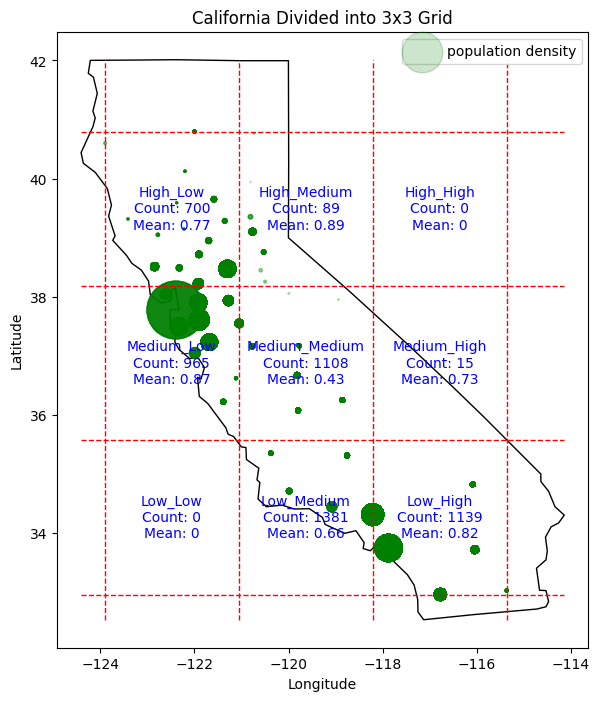

-123.90831360680001


In [72]:
#California Map initiator
import geopandas as gpd
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
states = gpd.read_file(url)
california = states[states['name'] == 'California']
min_lon, min_lat, max_lon, max_lat = california.total_bounds  # (west, south, east, north)

#### Plot
fig, ax = plt.subplots(figsize=(8, 8))
california.plot(ax=ax, edgecolor='black', facecolor='none')
ax.scatter(df.longitude,df.latitude,s=df.pop_density/10,c='green',label='population density',alpha=0.2)
# Draw Grid Lines
for lon in lon_bins:
    ax.vlines(lon, ymin=min_lat, ymax=max_lat, color='red', linestyle="--", linewidth=1)
for lat in lat_bins:
    ax.hlines(lat, xmin=min_lon, xmax=max_lon, color='red', linestyle="--", linewidth=1)
# Label Each Grid Cell with Area_ID
for i, lat_cat in enumerate(['Low', 'Medium', 'High']):
    for j, lon_cat in enumerate(['Low', 'Medium', 'High']):
        center_lon = (lon_bins[j] + lon_bins[j+1]) / 2
        center_lat = (lat_bins[i] + lat_bins[i+1]) / 2
        area_id = f"{lat_cat}_{lon_cat}"
        area_count = df[df["Area_ID"]==area_id]["Area_ID"].count()
        if area_id in area_correlation.keys():
            area_value = round(area_correlation[area_id],2)
        else:
            area_value=0
        area_text = f"{area_id}\nCount: {area_count}\nMean: {area_value}"
        ax.text(center_lon, center_lat, area_text, fontsize=10, color='blue', ha='center', va='center')
# Display Plot
plt.title("California Divided into 3x3 Grid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show();

In [37]:
# Count the percentage of missing values in df
percentage_nan = df.isna().sum()/df.shape[0]*100
print("Columns with missing values (in %)")
display(percentage_nan[percentage_nan>0])

Columns with missing values (in %)


HIFLD ID (GTET 100 Max Voltage)    2.631091
HIFLD ID (GTET 200 Max Voltage)    4.298684
Substation CASIO Name              0.185288
HIFLD ID (CAISO)                   4.020752
dtype: float64

In [38]:
# Get the distribution for the quantitative varibles
df.describe()

,Acres,Distance to Substation (Miles) GTET 100 Max Voltage,HIFLD ID (GTET 100 Max Voltage),Distance to Substation (Miles) GTET 200 Max Voltage,HIFLD ID (GTET 200 Max Voltage),Distance to Substation (Miles) CAISO,HIFLD ID (CAISO),Shape__Area,Shape__Length,pop_density,latitude,longitude
count,5397.000000,5397.000000,5255.000000,5397.000000,5165.000000,5397.000000,5180.000000,5.397000e+03,5397.000000,5397.000000,5397.000000,5397.000000
mean,27.839660,4.875213,305367.672883,9.005963,305585.657696,6.488376,304801.542278,1.126635e+05,799.673056,887.775913,36.033689,-119.465417
std,185.731791,5.598614,3270.527238,8.956602,3102.131691,5.257426,3049.650963,7.516313e+05,1549.493451,1261.604301,1.860967,2.021324
min,0.000413,0.000000,300007.000000,0.000000,300007.000000,0.000000,300004.000000,1.671917e+00,20.319768,1.800000,32.963784,-123.899773
25%,0.935973,1.364023,302331.000000,3.117734,303106.000000,2.655241,301858.000000,3.787762e+03,272.550078,103.300000,34.315507,-121.298071
50%,2.098715,2.766023,305578.000000,6.142767,305906.000000,5.061011,304448.000000,8.493241e+03,412.061886,307.100000,36.223108,-119.773799
75%,4.775675,6.182651,308662.000000,11.999466,308822.000000,8.782869,307282.000000,1.932655e+04,645.830476,1465.200000,37.550087,-118.209681
max,7438.603255,55.746475,310981.000000,102.224911,310527.000000,60.378808,310731.000000,3.010313e+07,35928.275147,17179.200000,40.796512,-115.359567


In [5]:
# Get the values for categorical variables with less than 10 categories
categorical_10 = ['Install Type', 'Urban or Rural', 'Combined Class', 'Percentile (GTET 100 Max Voltage)', 'Percentile (GTET 200 Max Voltage)', 'Percentile (CAISO)', 'Solar Technoeconomic Intersection']
for col in categorical_10:
    display(df[col].value_counts())
    print('--------------------------')

Install Type
Ground     2164
Rooftop    1841
Parking    1392
Name: count, dtype: int64

--------------------------


Urban or Rural
Urban    3631
Rural    1766
Name: count, dtype: int64

--------------------------


Combined Class
Rooftop - Urban    1710
Ground - Rural     1570
Parking - Urban    1327
Ground - Urban      594
Rooftop - Rural     131
Parking - Rural      65
Name: count, dtype: int64

--------------------------


Percentile (GTET 100 Max Voltage)
0 to 25th        1350
25th to 50th     1349
50th to 75th     1349
75th to 100th    1349
Name: count, dtype: int64

--------------------------


Percentile (GTET 200 Max Voltage)
25th to 50th     1350
0 to 25th        1349
50th to 75th     1349
75th to 100th    1349
Name: count, dtype: int64

--------------------------


Percentile (CAISO)
0 to 25th        1350
50th to 75th     1350
75th to 100th    1349
25th to 50th     1348
Name: count, dtype: int64

--------------------------


Solar Technoeconomic Intersection
Within     3790
Outside    1607
Name: count, dtype: int64

--------------------------


In [6]:
#display(df.head())
df = df.rename({'Distance to Substation (Miles) GTET 100 Max Voltage':'Distance100',
           'Percentile (GTET 100 Max Voltage)': 'Percentile100',
           'Substation Name GTET 100 Max Voltage': 'Name100',
           'HIFLD ID (GTET 100 Max Voltage)': 'ID100',
           'Distance to Substation (Miles) GTET 200 Max Voltage':'Distance200',
           'Percentile (GTET 200 Max Voltage)': 'Percentile200',
           'Substation Name GTET 200 Max Voltage': 'Name200',
           'HIFLD ID (GTET 200 Max Voltage)': 'ID200',
           'Distance to Substation (Miles) CAISO':'DistanceCAISO',
           'Percentile (CAISO)': 'PercentileCAISO',
           'Substation CASIO Name': 'NameCAISO',
           'HIFLD ID (CAISO)': 'IDCAISO',
           'Solar Technoeconomic Intersection': 'STI'
          }, axis=1)
df_no_ids = df.drop(['ID100', 'ID200', 'IDCAISO'], axis=1)
df_no_ids.head()

,County,Acres,Install Type,Urban or Rural,Combined Class,Distance100,Percentile100,Name100,Distance200,Percentile200,Name200,DistanceCAISO,PercentileCAISO,NameCAISO,STI,Shape__Area,Shape__Length
OBJECTID,,,,,,,,,,,,,,,,,
1,Alameda County,1.672639,Rooftop,Urban,Rooftop - Urban,0.162732,0 to 25th,Dixon Landing,2.272283,0 to 25th,Los Esteros,2.272283,0 to 25th,Los Esteros,Within,6768.954679,365.801336
2,Alameda County,1.897078,Rooftop,Urban,Rooftop - Urban,0.226728,0 to 25th,Dixon Landing,2.392816,0 to 25th,Los Esteros,2.392816,0 to 25th,Los Esteros,Within,7677.228982,366.909878
3,Alameda County,1.275783,Rooftop,Urban,Rooftop - Urban,0.426104,0 to 25th,Dixon Landing,2.537298,0 to 25th,Los Esteros,2.537298,0 to 25th,Los Esteros,Within,5162.935990,290.576263
4,Alameda County,1.424286,Rooftop,Urban,Rooftop - Urban,0.491306,0 to 25th,Dixon Landing,2.626699,0 to 25th,Los Esteros,2.626699,0 to 25th,Los Esteros,Within,5763.905754,344.705846
5,Alameda County,0.984429,Rooftop,Urban,Rooftop - Urban,0.795822,0 to 25th,Dixon Landing,2.728629,0 to 25th,Los Esteros,2.728629,25th to 50th,Los Esteros,Within,3983.859693,283.968425


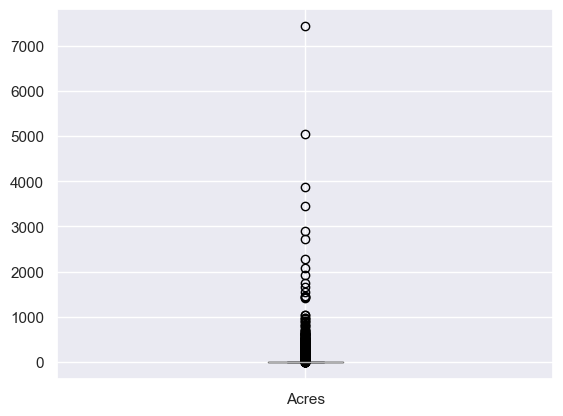

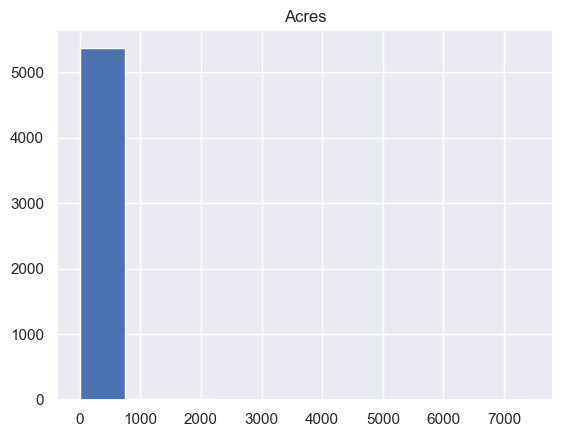

In [22]:
# After looking at the statistics of acres, we see that the mean is 27.8 but the median is 2! Highly skewed, there must be very extreme values

# Boxplot for acres
sns.set() # to change theme
df_no_ids.boxplot(column=['Acres'])
plt.show(); # yes, the boxplot is not even visible in normal scale. Note that only a few points are above the 1000 mark.

# Histogram for acres
df_no_ids.hist(column=['Acres'])
plt.show(); # points above 1000 are so small that they are not visible

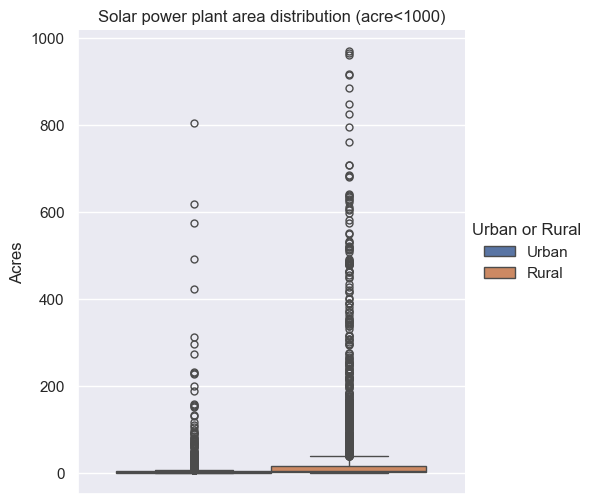

In [23]:
# check for outliers above 1000 acres
#df_no_ids[(df_no_ids['Acres']>1000)]
#df_no_ids['Acres']/df_no_ids['Shape__Area'] # just checking, for all data fixed conversion. Conversion factor corresponds to Area being in m^2 
# is the acre value correct? check if the conversion rate to m^2 is correct
df_no_ids.loc[(df_no_ids['Acres']>1000), 'Acres']/df_no_ids.loc[(df_no_ids['Acres']>1000), 'Shape__Area'] # yes, apparently not outliers, just extreme values

# retry visualization for points under 1000
sns.set() # to change theme
sns.catplot(y='Acres', data=df_no_ids[(df_no_ids['Acres']<1000)], kind='box', hue='Urban or Rural')
plt.title('Solar power plant area distribution (acre<1000)')
plt.show();

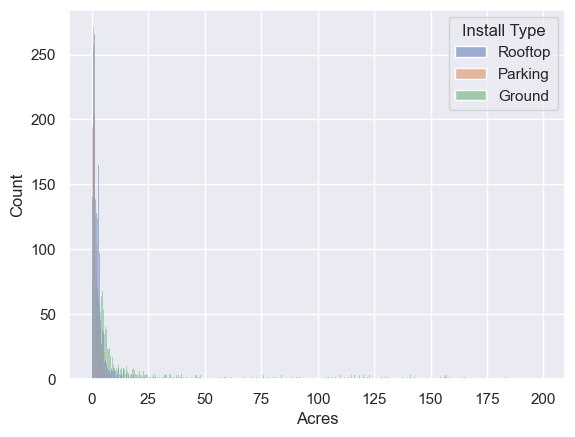

In [24]:
# Histogram for acres
sns.set() # to change theme
sns.histplot(data=df_no_ids[(df_no_ids['Acres']<200)], x="Acres", hue="Install Type")
plt.show();

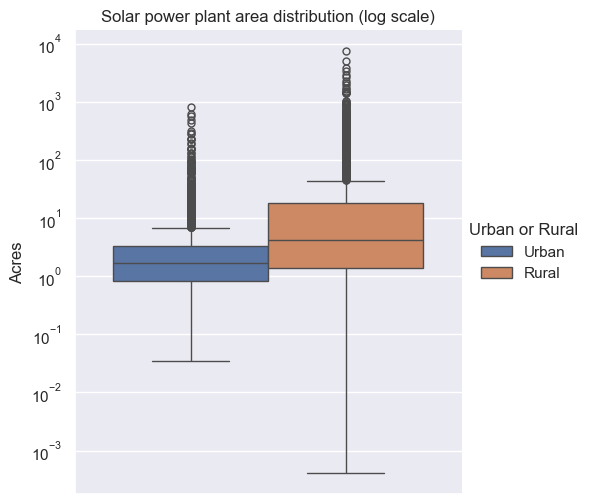

In [25]:
# Distribution of acres in log scale
sns.set() # to change theme
sns.catplot(y='Acres', data=df_no_ids, kind='box', hue='Urban or Rural')
plt.title('Solar power plant area distribution (log scale)')
plt.yscale('log')
plt.show();

<Figure size 3000x1000 with 0 Axes>

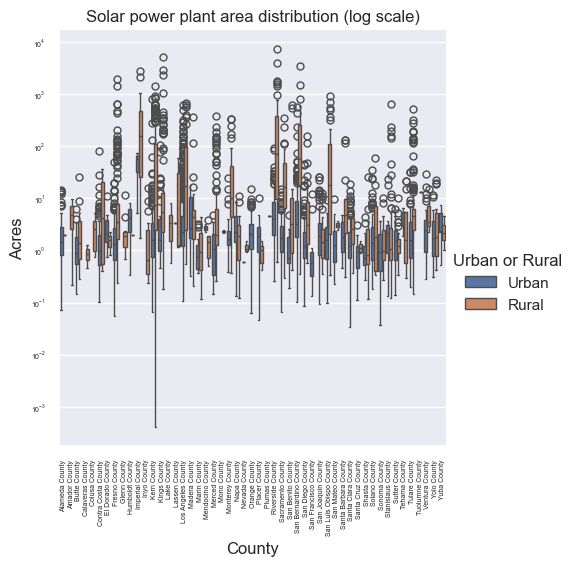

In [26]:
# Distribution of acres in log scale with county in x
sns.set() # to change theme
plt.figure(figsize=(30,10))
g = sns.catplot(x='County', y='Acres', data=df_no_ids, kind='box', hue='Urban or Rural')
plt.title('Solar power plant area distribution (log scale)')
plt.yscale('log')
g.set_xticklabels(rotation=90)
g.tick_params(labelsize=5)
plt.show();

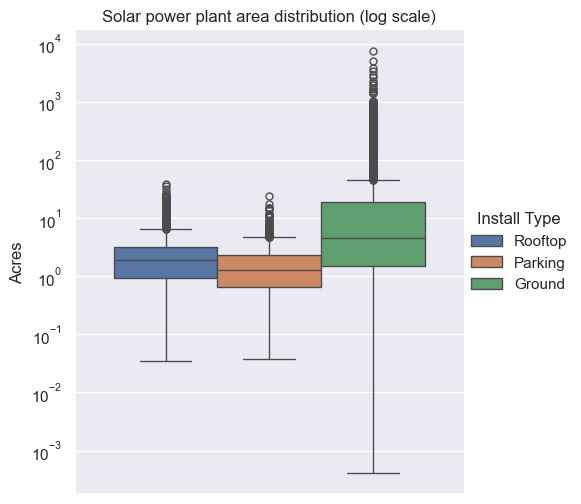

In [27]:
# Distribution of acres in log scale
sns.set() # to change theme
sns.catplot(y='Acres', data=df_no_ids, kind='box', hue='Install Type')
plt.title('Solar power plant area distribution (log scale)')
plt.yscale('log')
plt.show();

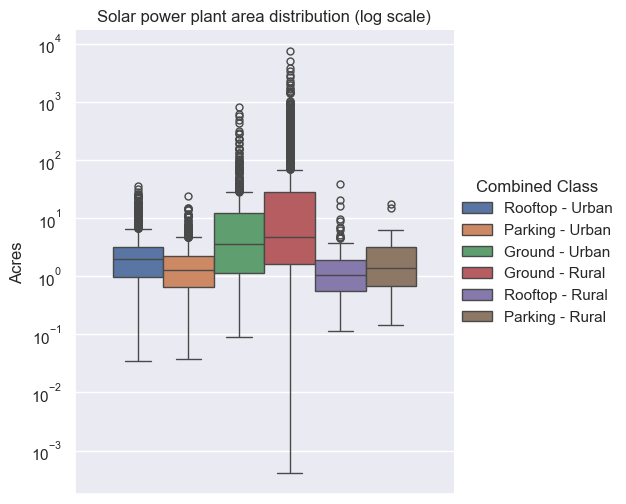

In [28]:
# Distribution of acres in log scale
sns.set() # to change theme
sns.catplot(y='Acres', data=df_no_ids, kind='box', hue='Combined Class')
plt.title('Solar power plant area distribution (log scale)')
plt.yscale('log')
plt.show();

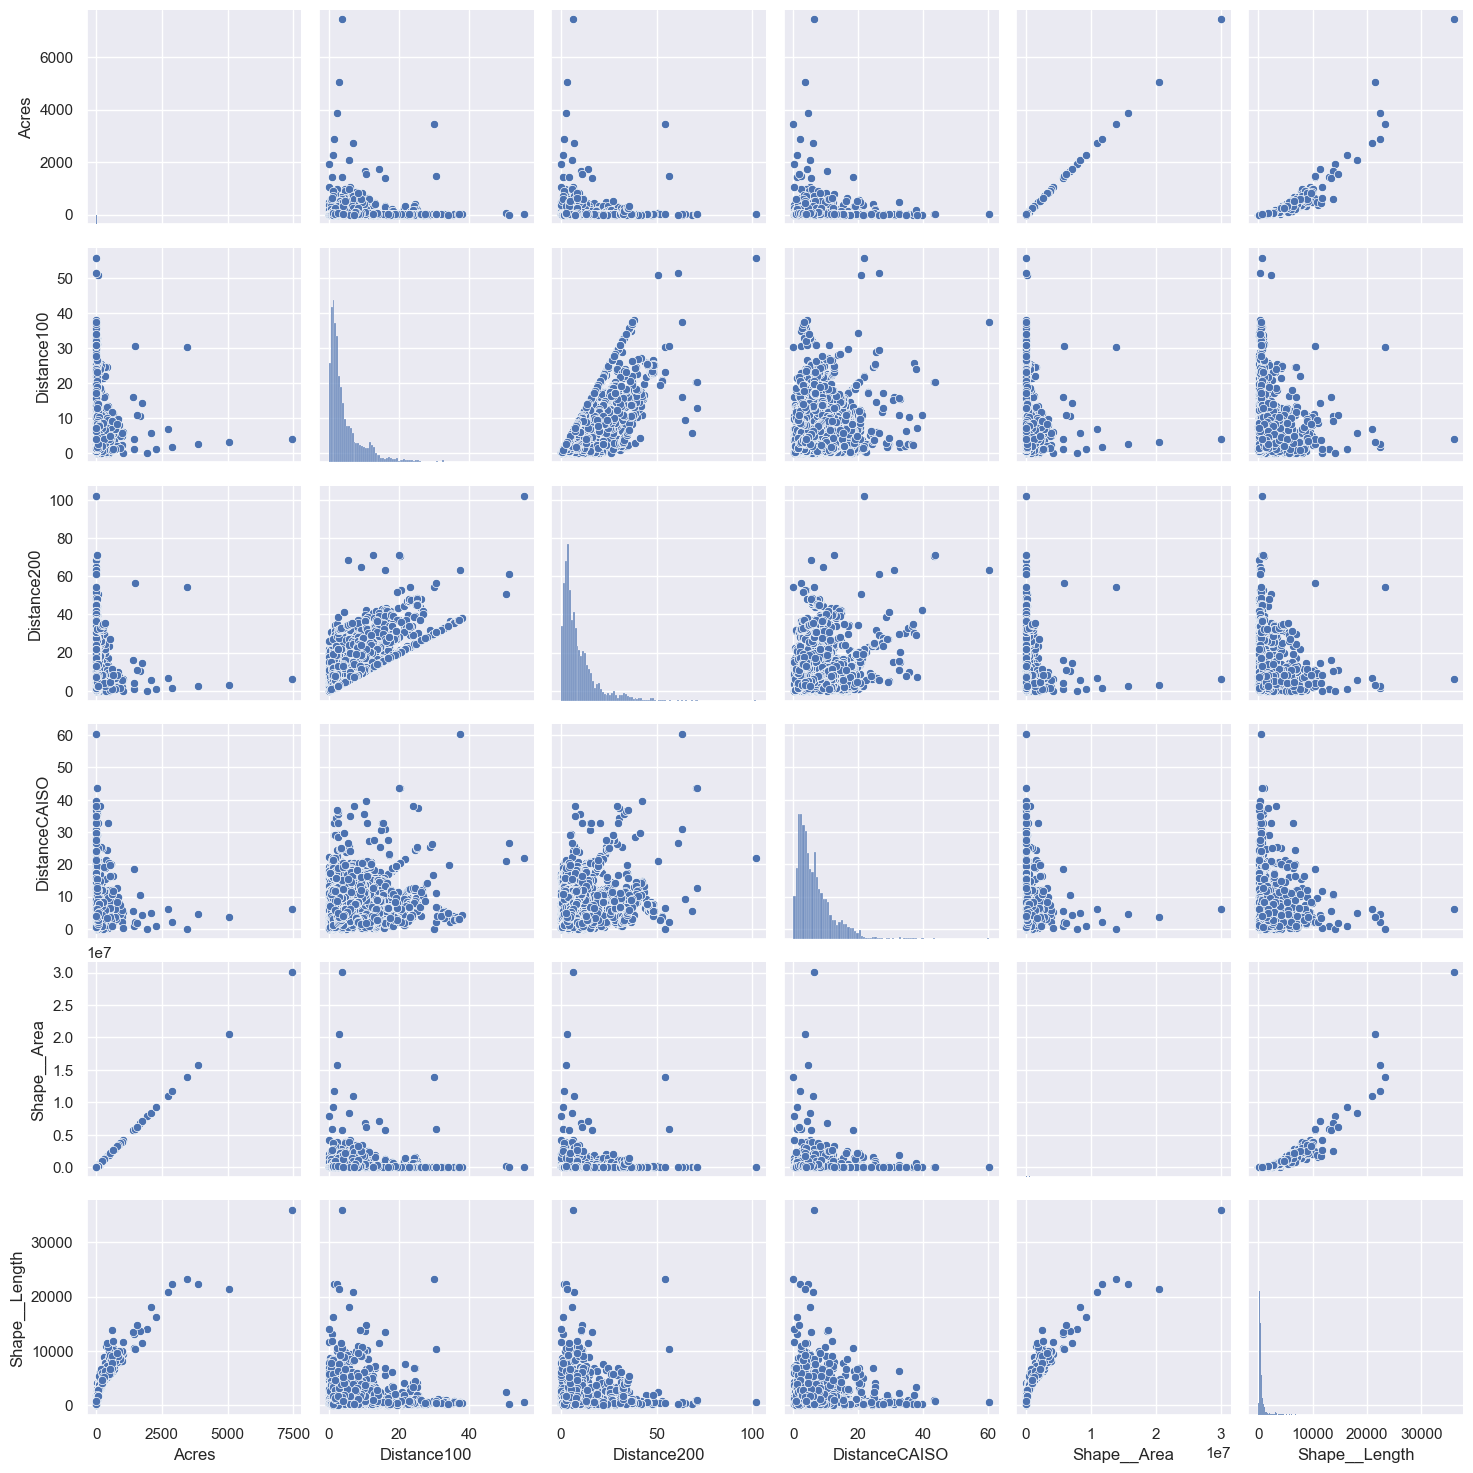

In [14]:
# pairplot for numeric variables
sns.set() # to change theme
sns.pairplot(df_no_ids)
plt.show();

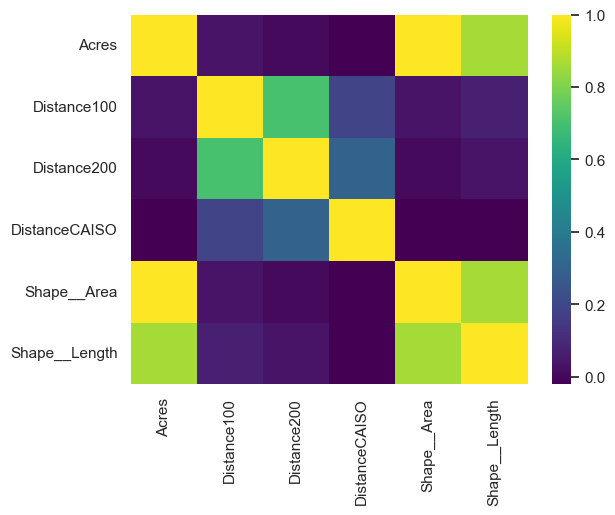

In [15]:
# correlation plot for numeric variables
#df_no_ids.head()
sns.heatmap(df_no_ids.corr(numeric_only=True), cmap='viridis')
plt.show();

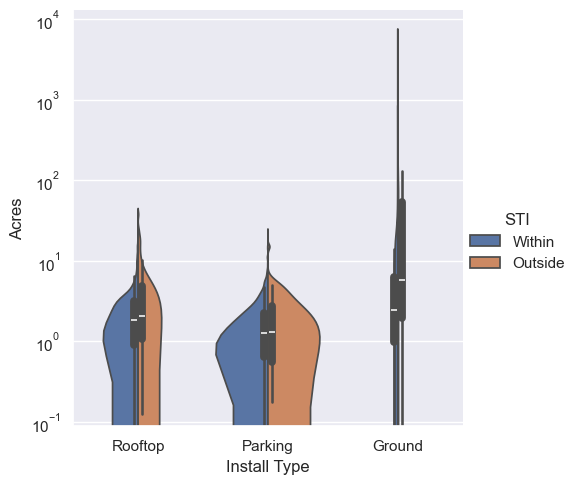

In [16]:
df_no_ids.head()
sns.catplot(x='Install Type', y='Acres', hue='STI', split=True, data=df_no_ids, kind='violin')
plt.yscale('log')
plt.show();

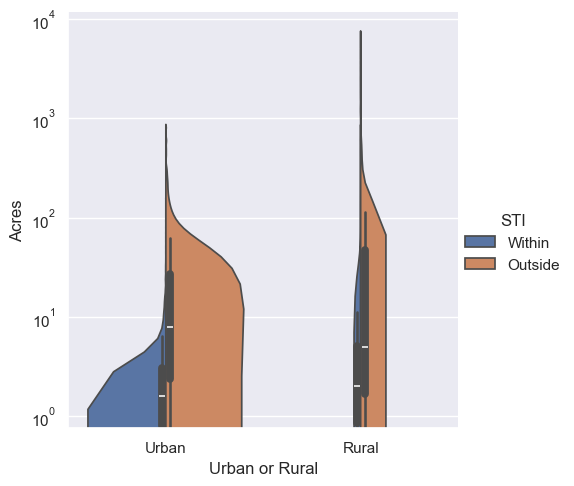

In [17]:
#Urban or Rural
sns.catplot(x='Urban or Rural', y='Acres', hue='STI', split=True, data=df_no_ids, kind='violin')
plt.yscale('log')
plt.show();

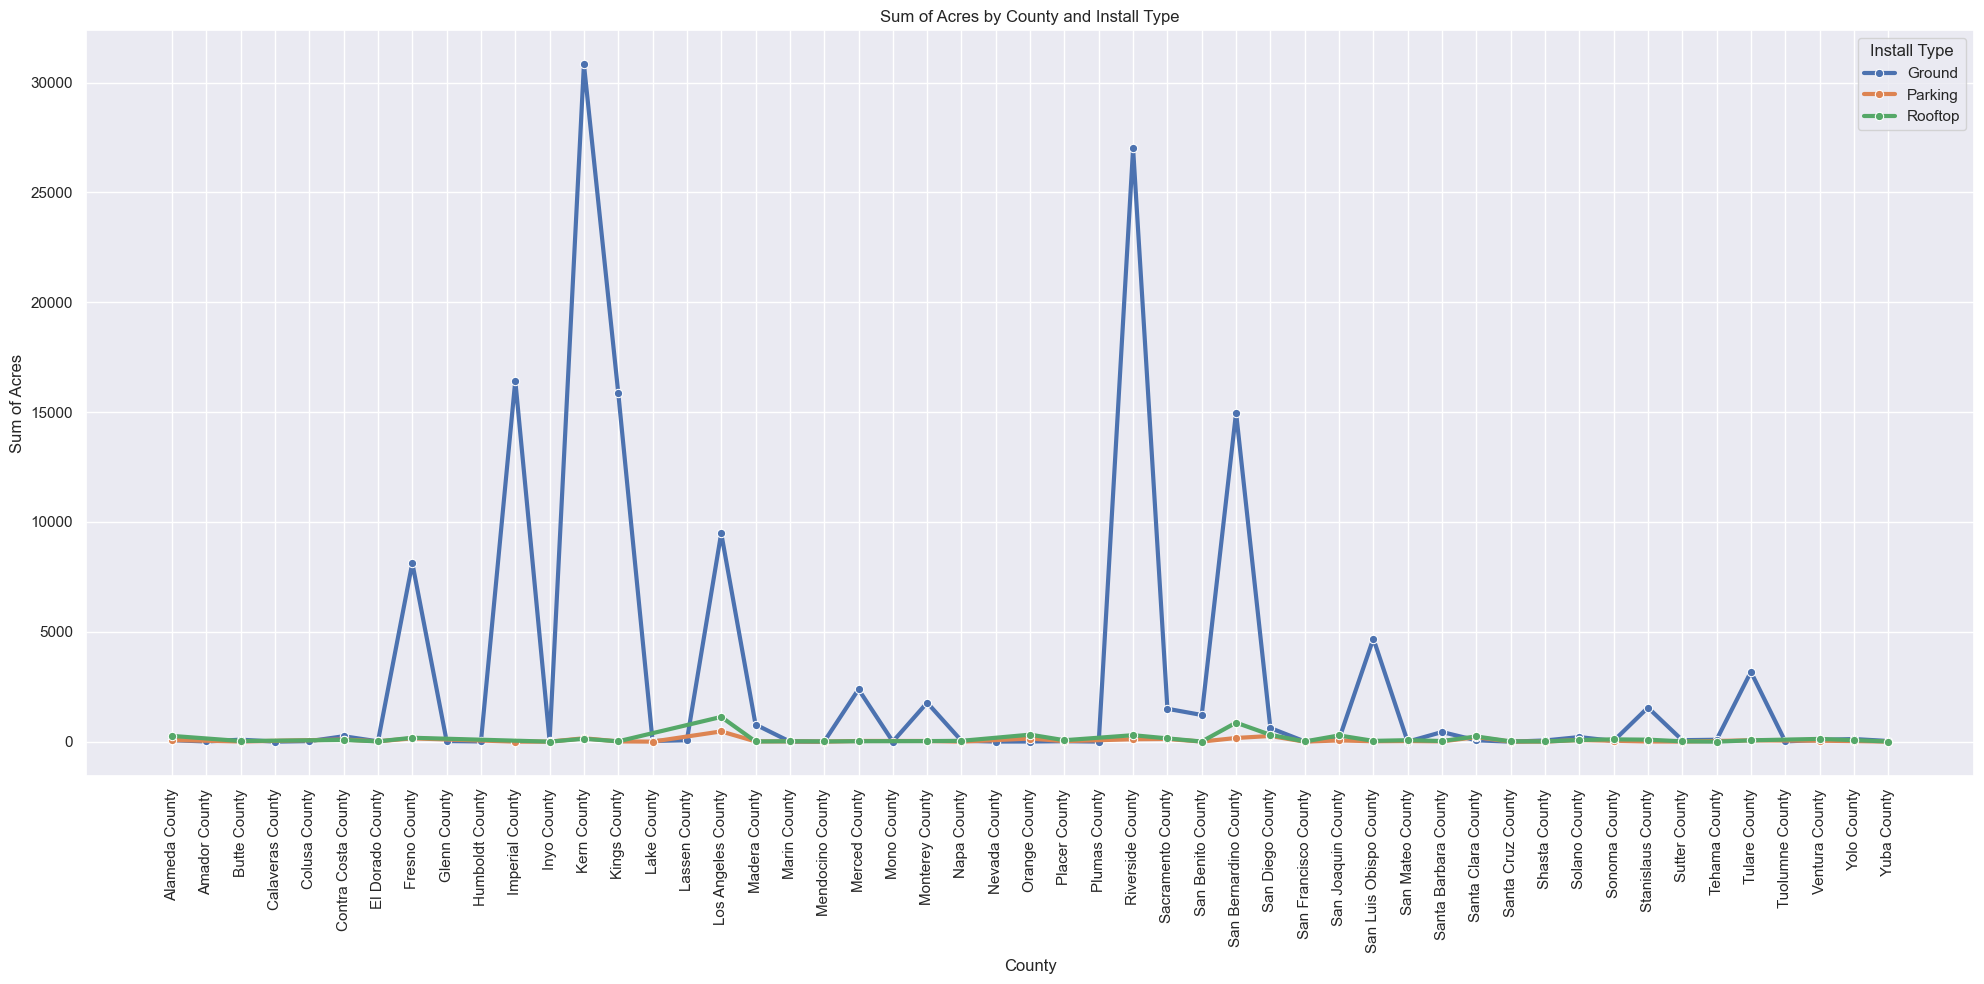

In [18]:
grouped_data = df_no_ids.groupby(['Install Type', 'County'])['Acres'].sum().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(
    data=grouped_data, 
    x='County', 
    y='Acres', 
    hue='Install Type', 
    marker='o',
    linewidth=3  # Increase the line width
)

# Add labels and title
plt.xlabel('County')
plt.ylabel('Sum of Acres')
plt.title('Sum of Acres by County and Install Type')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Install Type')
#plt.yscale('log')
plt.tight_layout()
plt.show();
#plt.savefig("SumByInstallType.png");

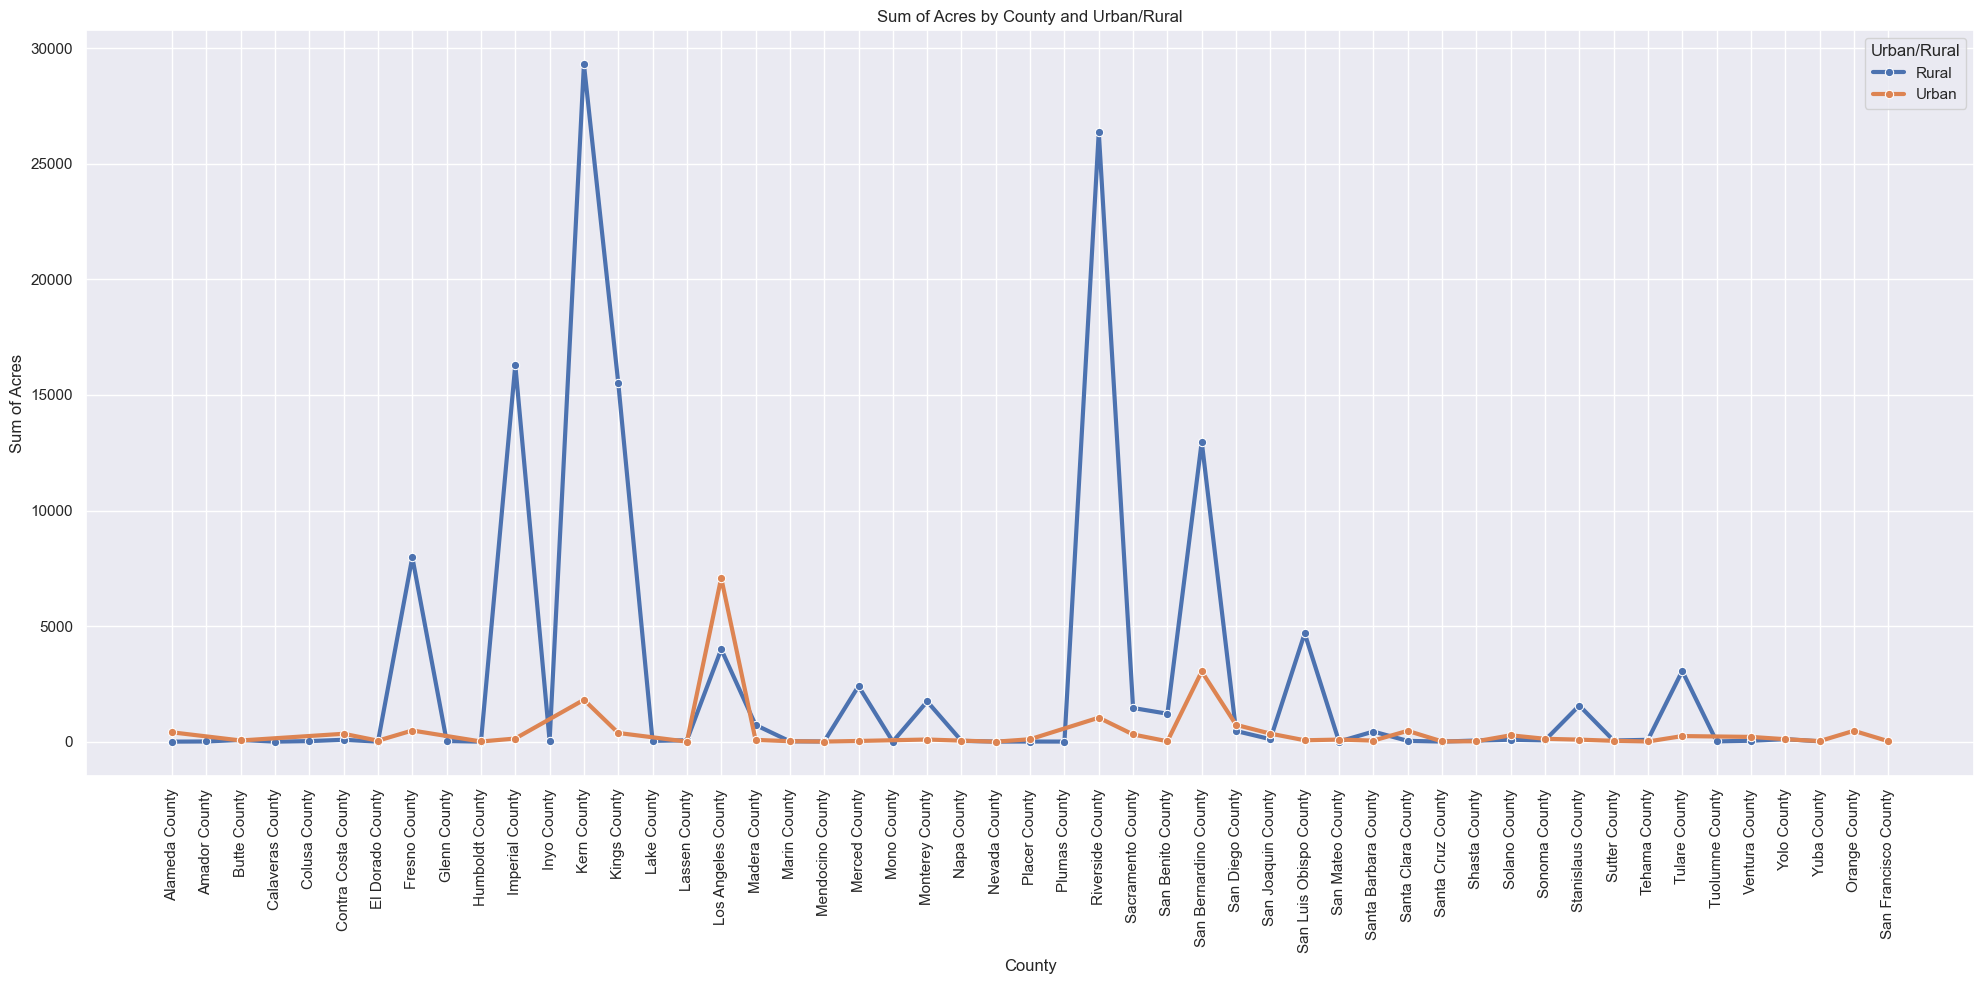

In [19]:
grouped_data = df_no_ids.groupby(['Urban or Rural', 'County'])['Acres'].sum().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(
    data=grouped_data, 
    x='County', 
    y='Acres', 
    hue='Urban or Rural', 
    marker='o',
    linewidth=3  # Increase the line width
)

# Add labels and title
plt.xlabel('County')
plt.ylabel('Sum of Acres')
plt.title('Sum of Acres by County and Urban/Rural')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Urban/Rural')
#plt.yscale('log')
plt.tight_layout()
plt.show();
#plt.savefig("SumByUrbanRural.png");

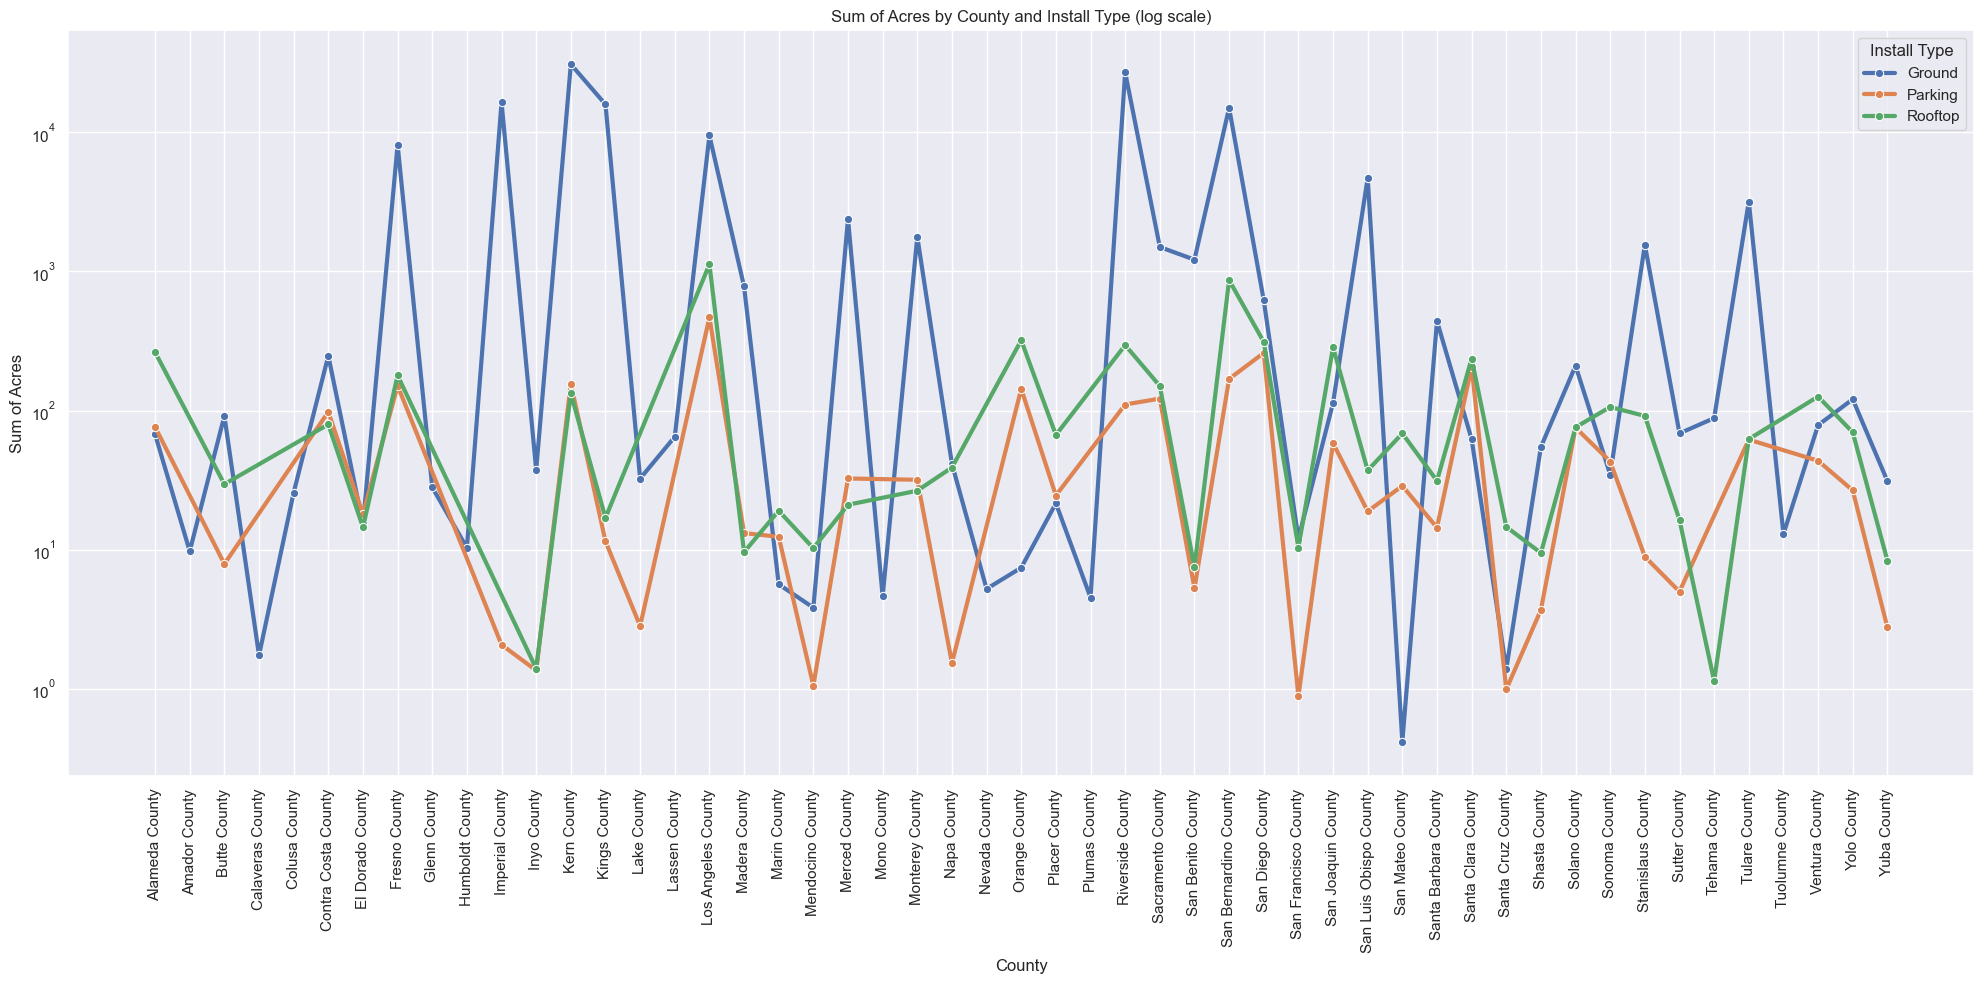

In [20]:
grouped_data = df_no_ids.groupby(['Install Type', 'County'])['Acres'].sum().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(
    data=grouped_data, 
    x='County', 
    y='Acres', 
    hue='Install Type', 
    marker='o',
    linewidth=3  # Increase the line width
)

# Add labels and title
plt.xlabel('County')
plt.ylabel('Sum of Acres')
plt.title('Sum of Acres by County and Install Type (log scale)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Install Type')
plt.yscale('log')
plt.tight_layout()
plt.show();
#plt.savefig("SumByInstallTypeLog.png");

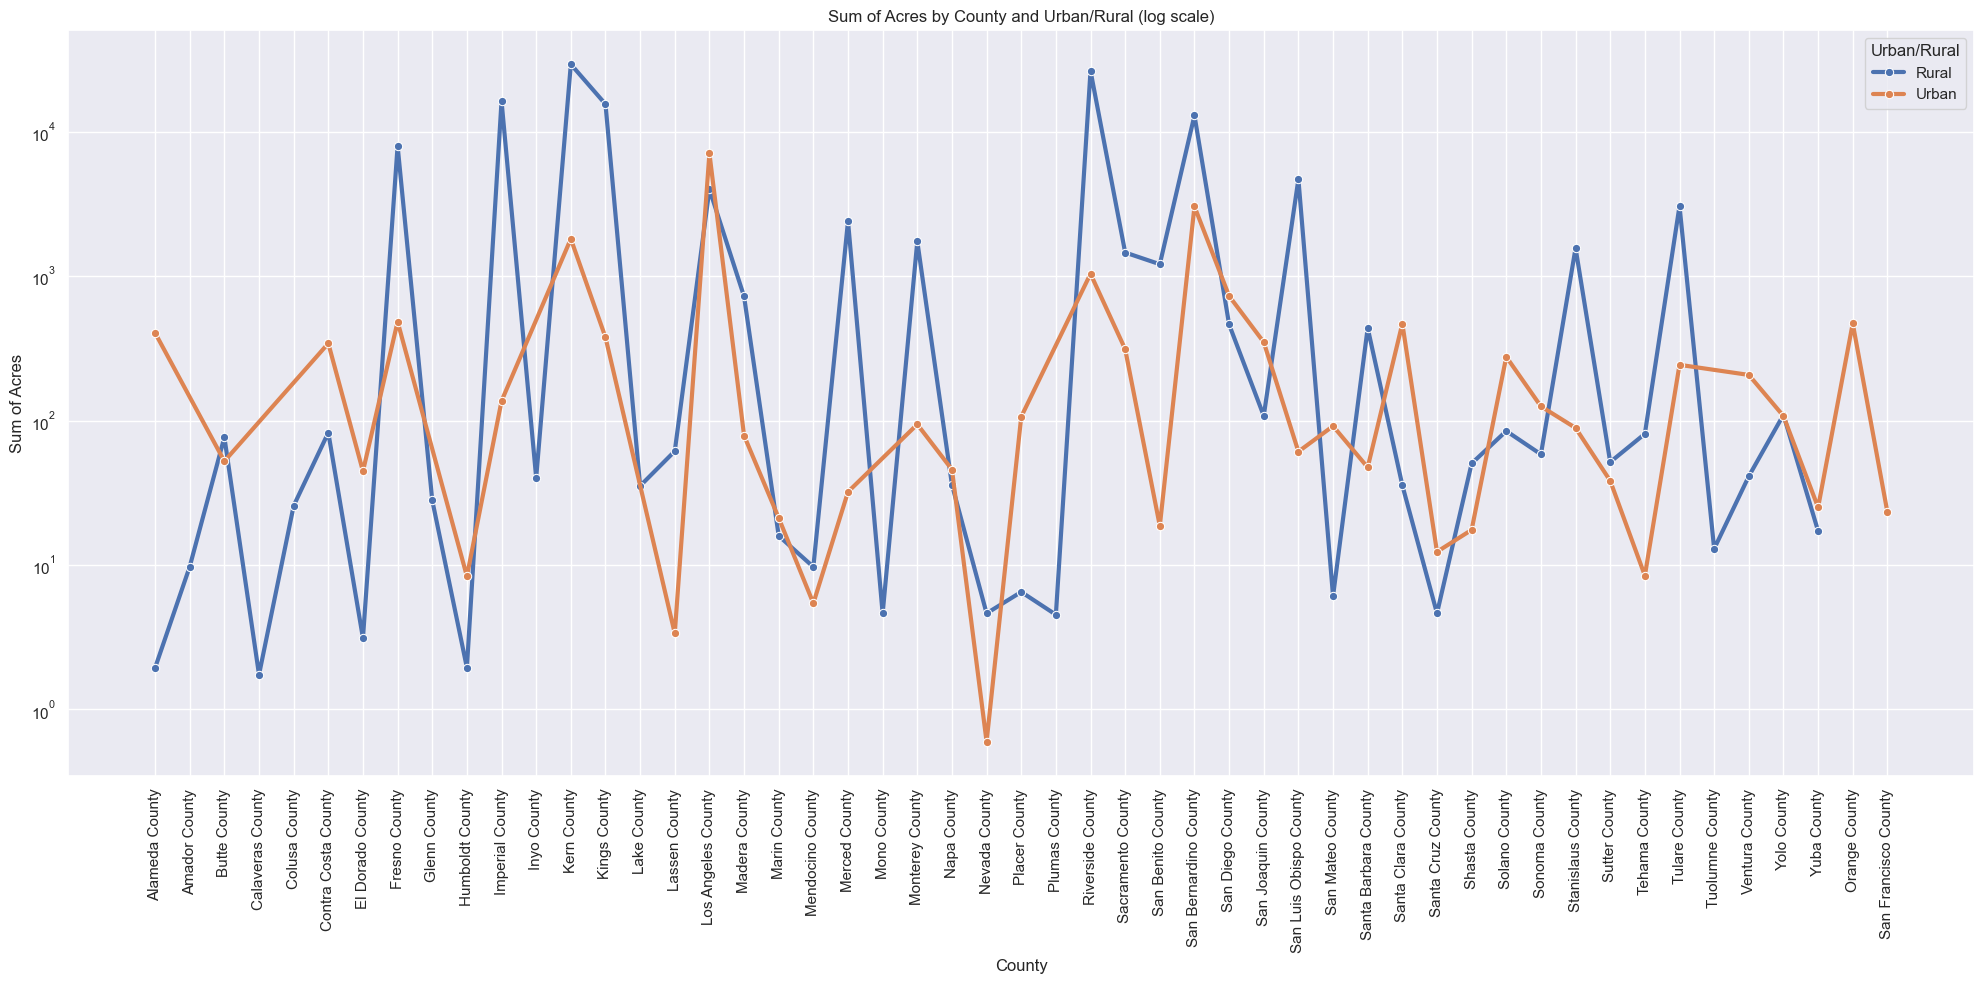

In [21]:
grouped_data = df_no_ids.groupby(['Urban or Rural', 'County'])['Acres'].sum().reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(
    data=grouped_data, 
    x='County', 
    y='Acres', 
    hue='Urban or Rural', 
    marker='o',
    linewidth=3  # Increase the line width
)

# Add labels and title
plt.xlabel('County')
plt.ylabel('Sum of Acres')
plt.title('Sum of Acres by County and Urban/Rural (log scale)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Urban/Rural')
plt.yscale('log')
plt.tight_layout()
plt.show();
#plt.savefig("SumByUrbanRuralLog.png");

,County,Acres,Install Type,Urban or Rural,Combined Class,Distance100,Percentile100,Name100,ID100,Distance200,Percentile200,Name200,ID200,DistanceCAISO,PercentileCAISO,NameCAISO,IDCAISO,STI,Shape__Area,Shape__Length
OBJECTID,,,,,,,,,,,,,,,,,,,,
1,Alameda County,1.672639,Rooftop,Urban,Rooftop - Urban,0.162732,0 to 25th,Dixon Landing,309200.0,2.272283,0 to 25th,Los Esteros,310258.0,2.272283,0 to 25th,Los Esteros,310258.0,Within,6768.954679,365.801336


Number of counties:  51
Number of ID100:  623
Number of ID200:  223
Number of IDCAISO:  213


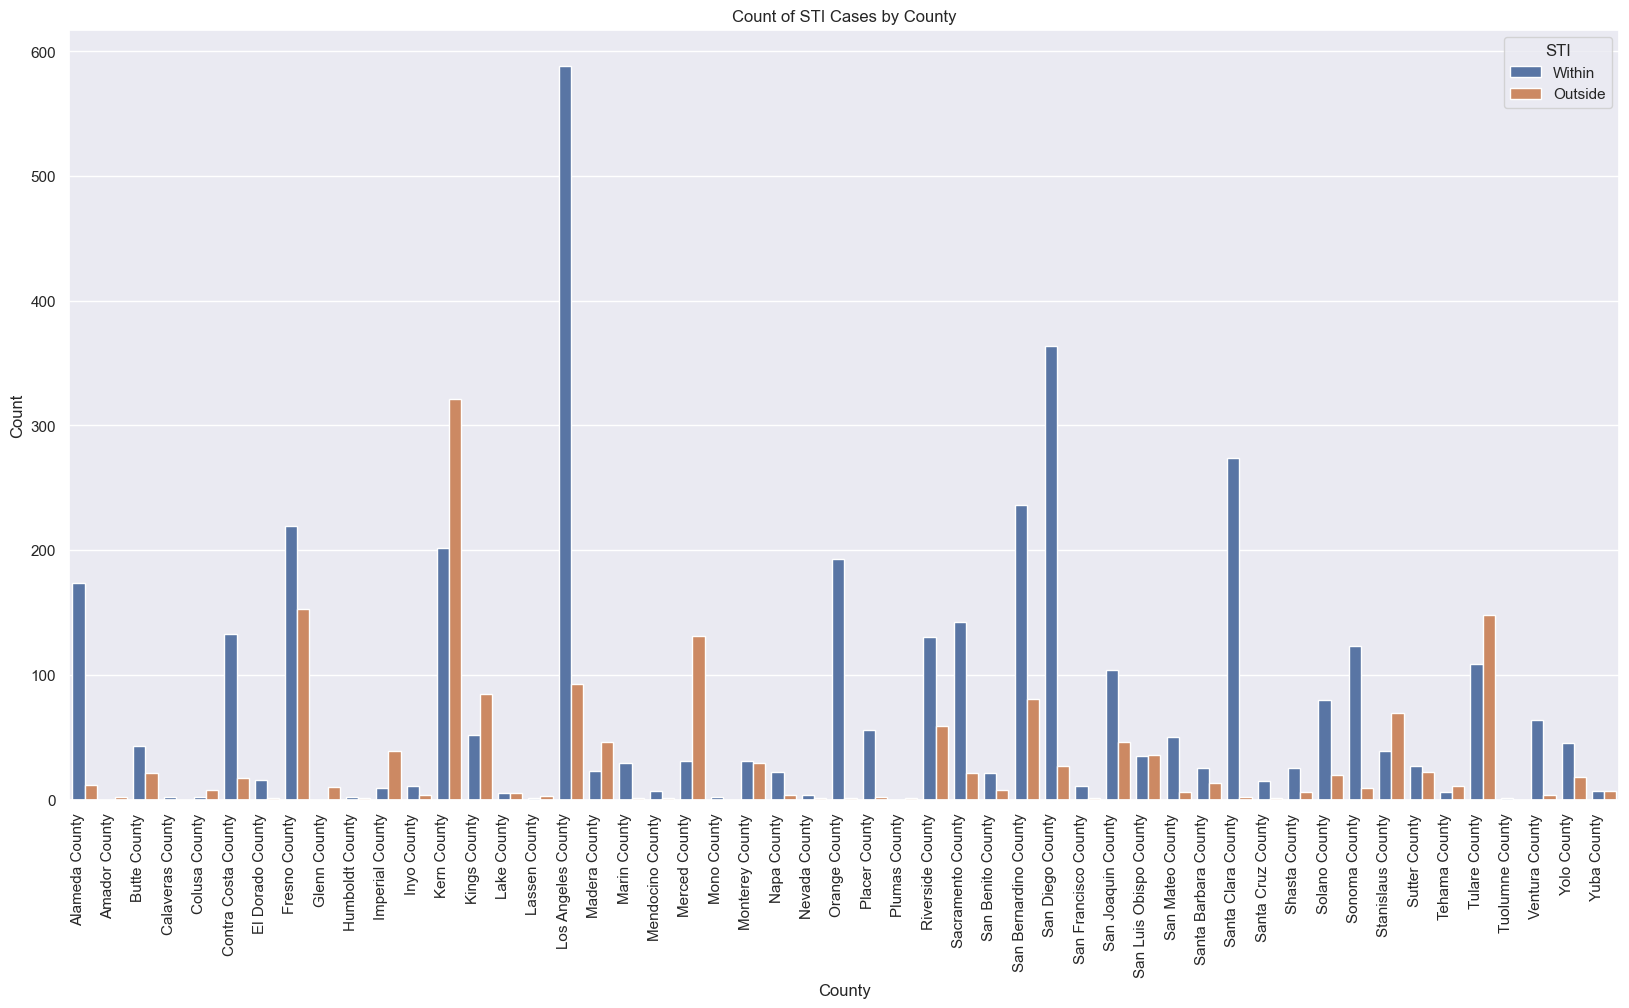

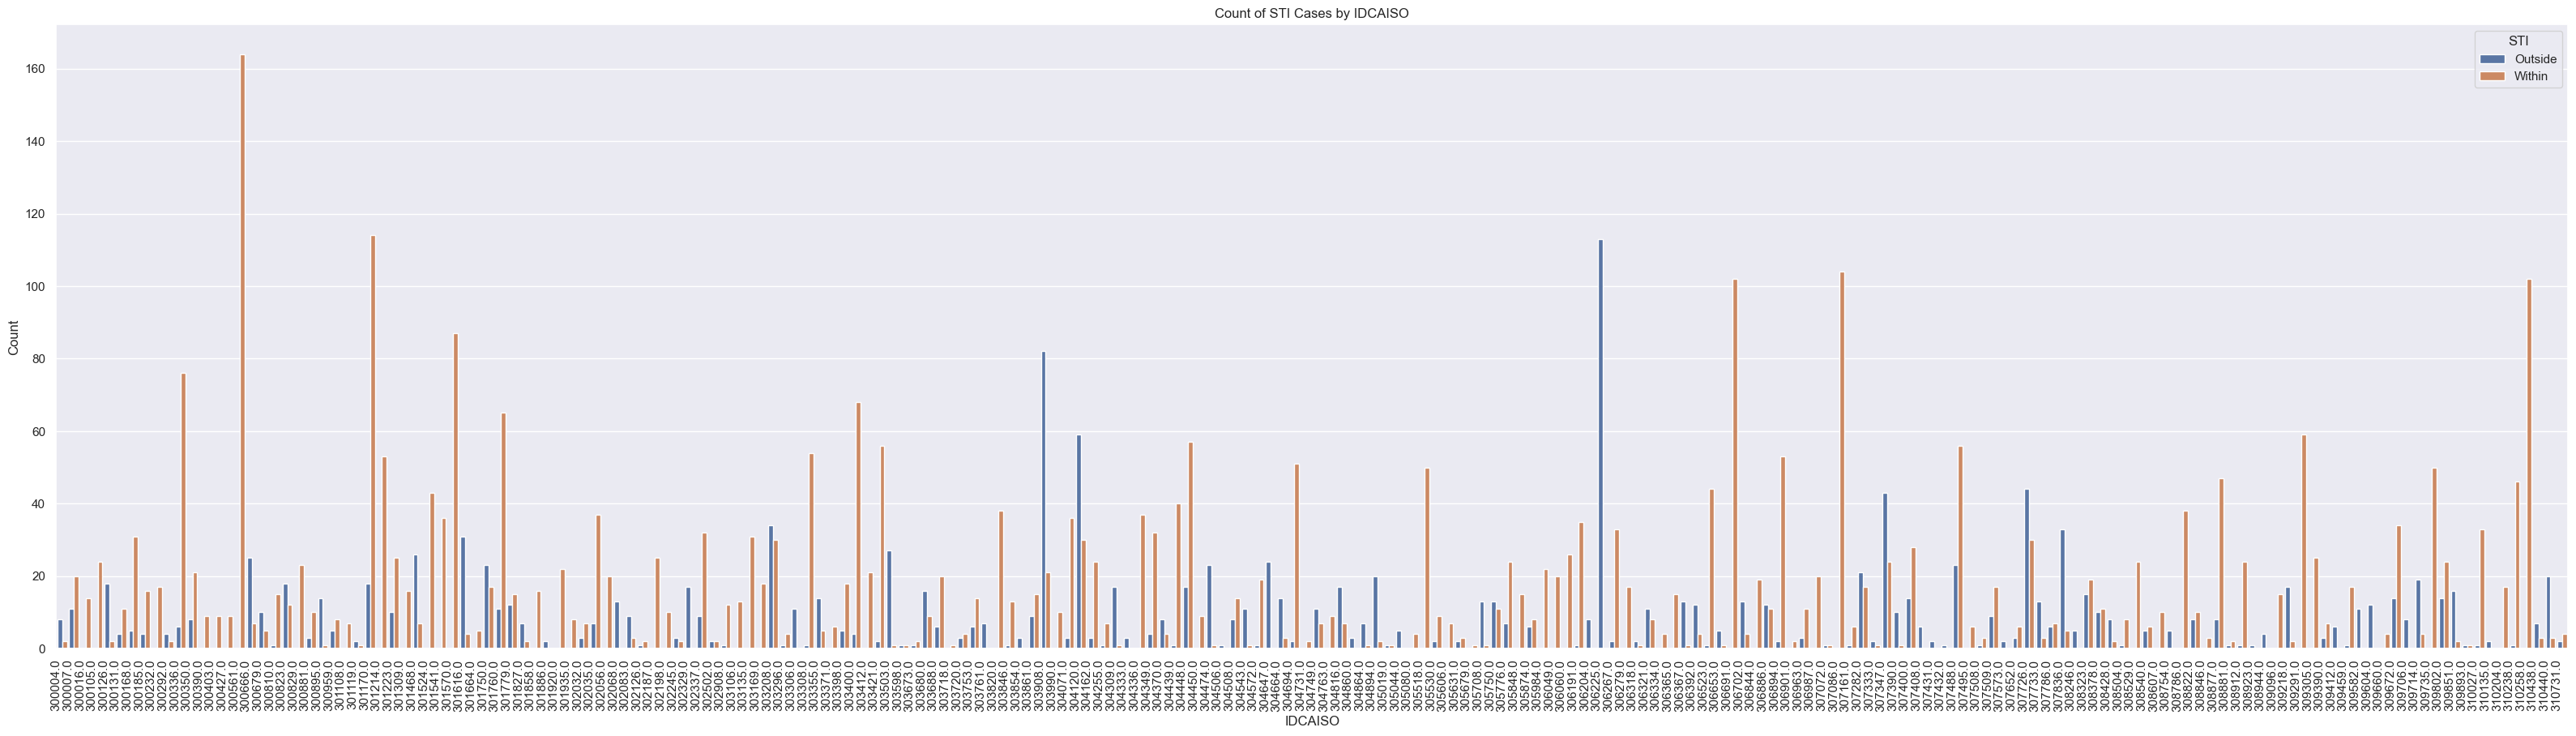

In [61]:
display(df.head(1))
print('Number of counties: ', len(df['County'].unique()))
print('Number of ID100: ', len(df['ID100'].unique()))
print('Number of ID200: ', len(df['ID200'].unique()))
print('Number of IDCAISO: ', len(df['IDCAISO'].unique()))
#df['ID100'].value_counts()

#grouped_data = df.groupby('County')['STI'].value_counts()
#grouped_data = df.groupby(['County', 'STI']).count()

plt.figure(figsize=(20, 10))
sns.countplot(data=df, x="County", hue="STI")
plt.xticks(rotation=90, ha="right")
plt.xlabel("County")
plt.ylabel("Count")
plt.title("Count of STI Cases by County")
plt.show();

plt.figure(figsize=(40, 10))
sns.countplot(data=df, x="IDCAISO", hue="STI")
plt.xticks(rotation=90, ha="right")
plt.xlabel("IDCAISO")
plt.ylabel("Count")
plt.title("Count of STI Cases by IDCAISO")
plt.show();